# HOW TO compare ESO catalogues

The ESO catalogue facility provides access to the collection of data that were produced by PIs of ESO programmes and then integrated into the ESO science archive through the Phase 3 process. The full list of available cataolgues could be found [here](https://www.eso.org/qi/).

To access the data you can use the [_programmatic access_](http://archive.eso.org/programmatic/#TAP) via the `tap_cat` TAP Service. The module `archive_catalogues` provides some simple `python` wrapper around this. For more details please see the [ESOAsg documentation](https://esoasg.readthedocs.io/en/latest/)

In [1]:
from ESOAsg.ancillary import astro
from ESOAsg import archive_catalogues
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib notebook

## Choose the catalogues you want to query

To begin, you need to know which catalogues you are interested to query. If in doubt, you can either check the [query interface webpage](https://www.eso.org/qi/) or you can obtain an astropy table of all catalogues (and all their versions) using:
```python
archive_catalogues.all_catalogues_info()
```

For this example, we will compare the physical parameter space covered by the catalogues [GAIAESO](http://archive.eso.org/scienceportal/home?data_collection=GAIAESO) and [AMBRE](http://archive.eso.org/scienceportal/home?data_collection=AMBRE). The content of which can be explored by running:
```python
archive_catalogues.all_catalogues_info(collections=['GAIAESO', 'AMBRE'])
```

In [3]:
catalogues = archive_catalogues.catalogues_info(collections=['GAIAESO', 'AMBRE'])
catalogues['collection', 'title', 'version', 'description', 'table_name'].show_in_notebook(display_length=5, show_row_index=False)

collection,title,version,description,table_name
AMBRE,Atmospheric Parameters and Chemical Abundances from Stellar Spectra - UVES,1,"Stellar radial velocity, atmospheric parameters (effective temperature, surface gravity, mean metallicity [M/H]) and enrichment in alpha-elements ([alpha/Fe]) resulting from the automatic analysis of the ESO spectral data archives of the FEROS, UVES, HARPS and FLAMES instruments with the MATISSE algorithm. This first release concerns the UVES data collected from 2000, March to 2010, November.",AMBRE_UVES_V1
AMBRE,Atmospheric Parameters and Chemical Abundances from Stellar Spectra,1,"Stellar radial velocity, atmospheric parameters (effective temperature, surface gravity, mean metallicity [M/H]) and enrichment in alpha-elements ([alpha/Fe]) resulting from the automatic analysis of the ESO spectral data archives of the FEROS, UVES, HARPS and FLAMES instruments with the MATISSE algorithm. This first release concerns the FEROS data collected from 2005, October to 2009, December.",AMBRE_V1
GAIAESO,Gaia-ESO spectroscopic survey,2,"Gaia-ESO is a large public spectroscopic survey1 carried out with FLAMES, targeting more than 10^5 stars, systematically covering all major components of the Milky Way, from halo to star-forming regions, providing the first homogeneous overview of the distributions of kinematics and elemental abundances.",GES_iDR4_PIII2016_Catalogue_v3_fits_V2


This allows to extract information such as `table_name` and `acknowledgment`:

In [4]:
tables = catalogues['table_name'].data
acknowledgments = catalogues['acknowledgment'].data
for table, acknowledgment in zip(tables, acknowledgments):
    print('The name of the table is: {}. \nThe corresponding acknowledgment is:\n{}.\n'.format(
        table, acknowledgment))

The name of the table is: AMBRE_UVES_V1. 
The corresponding acknowledgment is:
Please include the following acknowledgment in any publication that makes use of these data: Based on observations made with ESO Telescopes at the La Silla or Paranal Observatories. Data analysis by the OCA/ESO AMBRE project (Worley et al. 2012, A&A 542A, 48, and de Laverny et al. 2012, A&A 544A, 126), based on the MATISSE parametrisation algorithm (Recio-Blanco et al., 2006, MNRAS 370, 141)..

The name of the table is: AMBRE_V1. 
The corresponding acknowledgment is:
Please include the following acknowledgment in any publication that makes use of these data: Based on observations made with ESO Telescopes at the La Silla or Paranal Observatories. Data analysis by the OCA/ESO AMBRE project (Worley et al. 2012, A&A 542A, 48, and de Laverny et al. 2012, A&A 544A, 126), based on the MATISSE parametrisation algorithm (Recio-Blanco et al., 2006, MNRAS 370, 141)..

The name of the table is: GES_iDR4_PIII2016_Catalog

## Select the physical parameters to compare

You can glance the content of a catalogue by checking the name of the columns present in the associated list of collections:
```python
archive_catalogues.columns_info(collections=['GAIAESO', 'AMBRE'])
```

In [5]:
columns = archive_catalogues.columns_info(collections=['GAIAESO', 'AMBRE'])
columns.show_in_notebook(show_row_index=False, display_length=6)

table_name,column_name,ucd,datatype,description,unit
AMBRE_V1,DP_ID,meta.id;meta.main,CHAR,ESO Data set identifier,
AMBRE_V1,OBJECT,meta.id,CHAR,Object designation,
AMBRE_V1,TARGNAME,meta.id,CHAR,Target designation,
AMBRE_V1,RAJ2000,pos.eq.ra;meta.main,REAL,"Telescope pointing (right ascension, J2000)",deg
AMBRE_V1,DEJ2000,pos.eq.dec;meta.main,REAL,"Telescope pointing (declination, J2000)",deg
AMBRE_V1,MJD_OBS,obs;time.epoch,DOUBLE,Start of observation date,MJD
AMBRE_V1,EXPTIME,obs.exposure,REAL,Total integration time,s
AMBRE_V1,SNR,stat.snr,REAL,Signal-to-noise ratio,
AMBRE_V1,SNR_FLAG,meta.code,CHAR,Quality of SNR estimate. (C)rude or (R)efined,
AMBRE_V1,EXTREME_EMISSION_LINE_FLAG,meta.code,CHAR,T if Extreme Emission Lines detected -> No analysis,


Let assume we are interested in comparing the effective temperature and the gravity of the stars present in the queried catalogues. While these could have different names in different catalogues, it is possible to recover them using the `ucd` tokens. Specifically we select:
* for the effective temperatured: 
```python
columns['ucd']=='phys.temperature.effective'
```
* for the gravity:
```python
columns['ucd']=='phys.gravity'
```

In [6]:
columns[(columns['ucd']=='phys.temperature.effective') | (columns['ucd']=='phys.gravity')].show_in_notebook(
    show_row_index=False, display_length=6)

table_name,column_name,ucd,datatype,description,unit
AMBRE_V1,TEFF,phys.temperature.effective,REAL,Effective Temperature,K
AMBRE_V1,LOG_G,phys.gravity,REAL,Surface Gravity (log g),cm/s^2
GES_iDR4_PIII2016_Catalogue_v3_fits_V2,TEFF,phys.temperature.effective,REAL,Effective Temperature,K
GES_iDR4_PIII2016_Catalogue_v3_fits_V2,LOGG,phys.gravity,REAL,Log Surface Gravity (gravity in cms$^{-2}$),dex
AMBRE_UVES_V1,TEFF,phys.temperature.effective,REAL,Effective Temperature,K
AMBRE_UVES_V1,LOG_G,phys.gravity,REAL,Surface Gravity (log g),cm.s**(-2)


The result is thus stored in an `astropy.table`:

## Explore the data

Now you have all the information to obtain data from the `AMBRE` and `GAIAESO` catalogues.

Note that, to speed up the process, we queried the table for only the columns we are interested in, i.e. 'TEFF', 'LOG_G' for `AMBRE` and 'TEFF', 'LOGG' for `GAIAESO`. Note that the collection `AMBRE` contains to tables (`AMBRE_V1` and `AMBRE_UVES_V1`), thus data will be stored in a list of astropy tables (one per table).

In [7]:
selected_columns_AMBRE = ['TEFF', 'LOG_G']
selected_columns_GAIAESO = ['TEFF', 'LOGG']

AMBRE = archive_catalogues.get_catalogues(collections='AMBRE', 
                                          columns=selected_columns_AMBRE)
GAIAESO = archive_catalogues.get_catalogues(collections='GAIAESO', 
                                            columns=selected_columns_GAIAESO)

[INFO]    :: The query to AMBRE_V1 returned 18618 entries (with a limit set to maxrec=18618)
[INFO]    :: The query to AMBRE_UVES_V1 returned 51897 entries (with a limit set to maxrec=51897)
[INFO]    :: The query to GES_iDR4_PIII2016_Catalogue_v3_fits_V2 returned 25533 entries (with a limit set to maxrec=25533)


Now the coverage of the different surveys on the effective temperature vs. gravity plot can be plotted.

<IPython.core.display.Javascript object>


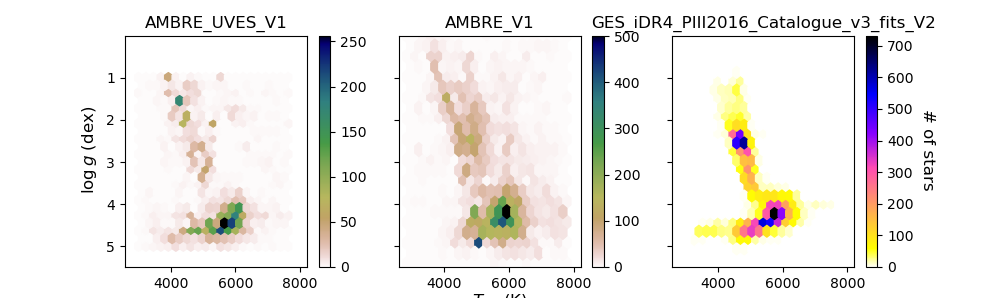

In [47]:
tables = ['AMBRE_UVES_V1', 'AMBRE_V1', 'GES_iDR4_PIII2016_Catalogue_v3_fits_V2']
catalogues = AMBRE + [GAIAESO]
cmaps = ['gist_earth_r', 'gist_earth_r', 'gnuplot2_r']

fig, axes = plt.subplots(ncols=3, nrows=1, 
                         sharex=True, sharey=True,
                        figsize=(10,3))

for table, catalogue, ax, cmap in zip(tables, catalogues, axes, cmaps):
    if table.startswith('AMBRE'):
        TEFF = catalogue[selected_columns_AMBRE[0]]
        LOGG = catalogue[selected_columns_AMBRE[1]]
    else:
        TEFF = catalogue[selected_columns_GAIAESO[0]]
        LOGG = catalogue[selected_columns_GAIAESO[1]]
    ax.set_title(r'{}'.format(table))
    ax.set_ylim(5.49,0.01)
    ax_plot = ax.hexbin(TEFF, LOGG, cmap=cmap, gridsize=20)
    plt.colorbar(ax_plot, ax=ax)
    
fig.text(0.5, -0.02, r'$T_{eff}$ (K)', ha='center', size='large')
fig.text(0.08, 0.5, r'$\log\,g$ (dex)', va='center', rotation='vertical', size='large')
fig.text(0.92, 0.5, r'# of stars', va='center', rotation=-90., size='large')

plt.show()
plt.savefig('ambre_vs_gaiaeso.jpg', format='jpg', bbox_inches='tight')

Or, to show the distribution of the data in `AMBRE_UVES_V1` in bin normalized in $\log_{10}$

<IPython.core.display.Javascript object>


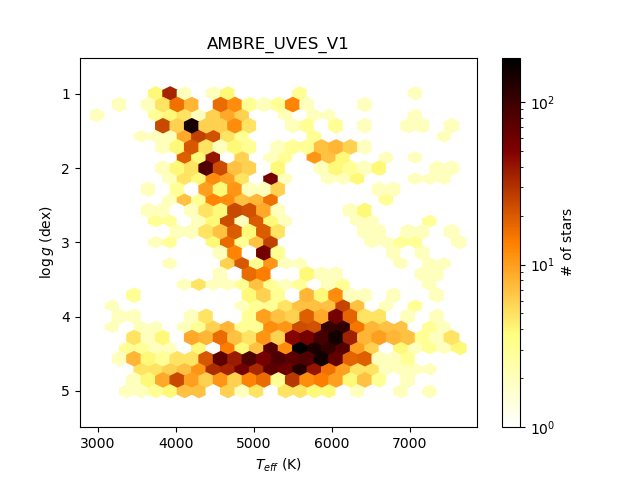

In [55]:
plt.figure()

TEFF = AMBRE[0][selected_columns_AMBRE[0]]
LOGG = AMBRE[0][selected_columns_AMBRE[1]]
plt.title(r'{}'.format('AMBRE_UVES_V1'))
plt.hexbin(TEFF, LOGG, cmap='afmhot_r', gridsize=25, bins='log') 
plt.ylim(5.49,0.51)
plt.xlabel(r'$T_{eff}$ (K)')
plt.ylabel(r'$\log\,g$ (dex)')
cbar = plt.colorbar()
cbar.set_label(r'# of stars')
plt.show()
plt.savefig('ambre_uves.jpg', format='jpg', bbox_inches='tight')